### Imports

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm, trange
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from prince import FAMD, PCA
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

os.chdir(Path(sys.path[0]).parent)

#Our own librabries
from src.clean import clean_data, regroup_crop
from src.utils import add_Loss, add_crop_categories, add_climate_clusters 
from src.plot import plot_on_map, display_parallel_coordinates_centroids

## Import and clean data 

In [2]:
# Select the dataset of one season of one year
YEAR = 2019

# Path to the dataset
pathData_R = f"data/merged_data/RawData_{YEAR}_Rabi.csv"
pathData_K= f"data/merged_data/RawData_{YEAR}_Kharif.csv"


df_R = pd.read_csv(pathData_R)
df_K = pd.read_csv(pathData_K)

FileNotFoundError: [Errno 2] No such file or directory: 'data/merged_data/RawData_2019_Rabi.csv'

In [ ]:
# Clean an add loss to data
df_R=add_Loss(clean_data(df_R))
df_K=add_Loss(clean_data(df_K))

df_R.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss
key,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.014822,0.0,0.0,0.000000,0.882341,0.645266,0.000000,1.078638e+05
andhra pradesh_anantapur_vajrakarur___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.000000,0.0,0.0,0.000000,0.217446,0.000000,0.347871,0.000000e+00
andhra pradesh_anantapur_gooty___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06
andhra pradesh_anantapur_guntakal___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06
andhra pradesh_anantapur_pamidi___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06


In [ ]:
# NORMALISATION OF DATA (uses : for FAMD and for computing the DB criteria)
data_R=df_R.copy(deep=True)
data_K=df_K.copy(deep=True)
scale = StandardScaler()
data_R.loc[:,data_R.columns !='Crop']=scale.fit_transform(data_R.loc[:,data_R.columns !='Crop'])
data_K.loc[:,data_K.columns !='Crop']=scale.fit_transform(data_K.loc[:,data_K.columns !='Crop'])

# Data for Davis_Bouldin criteria 
collumns_db = [f'Lp_{i}' for i in range(2011,2018)]
data_R_db=data_R[collumns_db]
data_K_db=data_K[collumns_db]
data_R_db.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017
key,,,,,,,
andhra pradesh_anantapur_vidapanakal___,-0.665553,-0.71241,-0.786921,-0.997198,2.895587,1.590735,-0.451395
andhra pradesh_anantapur_vajrakarur___,-0.744326,-0.71241,-0.786921,-0.997198,0.141328,-0.549593,0.802982
andhra pradesh_anantapur_gooty___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006
andhra pradesh_anantapur_guntakal___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006
andhra pradesh_anantapur_pamidi___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006


## K-means (with only the Lp data)

#### Find the optimal number of clusters for both season

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Rabi with k = 2 :  1.1449840670484899
db index for Rabi with k = 3 :  0.8789463131715362
db index for Rabi with k = 4 :  1.2566712101868305
db index for Rabi with k = 5 :  1.2782729113839302
db index for Rabi with k = 6 :  1.3795731831557776
db index for Rabi with k = 7 :  1.2816571762436182
db index for Rabi with k = 8 :  1.3040776072129296
db index for Rabi with k = 9 :  1.2796085515533795
db index for Rabi with k = 10 :  1.2737969396311588
db index for Rabi with k = 11 :  1.2576176911274044
db index for Rabi with k = 12 :  1.2278183969366798
db index for Rabi with k = 13 :  1.1983144566216248
db index for Rabi with k = 14 :  1.2121745499126104
db index for Rabi with k = 15 :  1.2403679375261758


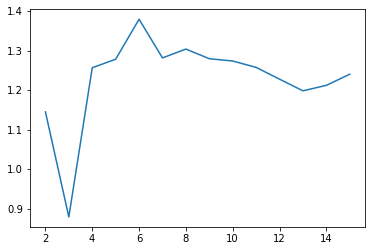

In [5]:
Db_R=[]
for i in trange(2,16) :
    nb_clusters = i
    kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, n_init=15, random_state=45).fit(data_R_db)
    kmeans_labels_R = kmeans_R.labels_
    db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
    Db_R.append(db_index)
    print(f"db index for Rabi with k = {nb_clusters} : ", db_index)
plt.plot(np.arange(2,16), Db_R)

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Kharif with k = 2 :  1.4655587671811812
db index for Kharif with k = 3 :  1.2857888734880225
db index for Kharif with k = 4 :  1.4850622060804715
db index for Kharif with k = 5 :  1.4254887469404514
db index for Kharif with k = 6 :  1.4264802707307076
db index for Kharif with k = 7 :  1.3718302945675849
db index for Kharif with k = 8 :  1.3505520872125247
db index for Kharif with k = 9 :  1.3498275263769104
db index for Kharif with k = 10 :  1.333617605398722
db index for Kharif with k = 11 :  1.2951664133413578
db index for Kharif with k = 12 :  1.2987538626155124
db index for Kharif with k = 13 :  1.2396080143365924
db index for Kharif with k = 14 :  1.2972231384003814
db index for Kharif with k = 15 :  1.2660613064401554


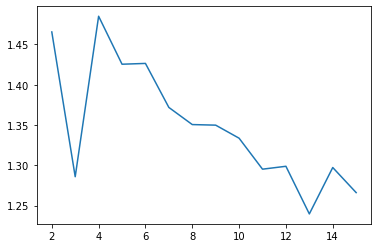

In [44]:
Db_K=[]
for i in trange(2,16) :
    nb_clusters = i
    kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, n_init=15, random_state=45).fit(data_K_db)
    kmeans_labels_K = kmeans_K.labels_
    db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
    Db_K.append(db_index)
    print(f"db index for Kharif with k = {nb_clusters} : ", db_index)
plt.plot(np.arange(2,16), Db_K)

#### Compute and save optimal clusters

In [21]:
nb_clusters_R = 7
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, n_init=15, random_state=45).fit(data_R_db)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

nb_clusters_K = 13
kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, n_init=15, random_state=45).fit(data_K_db)
kmeans_labels_K = kmeans_K.labels_
db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
print(f"db index for Rabi with k = {nb_clusters_K} : ", db_index)

db index for Rabi with k = 7 :  1.2816571762436182
db index for Rabi with k = 13 :  1.2396080143365924


In [22]:
# Save the optimal clusters
labels_R = pd.DataFrame(kmeans_labels_R)
databis_R=df_R.reset_index()
labels_R=pd.concat((databis_R['key'],labels_R),axis=1).set_index('key')
labels_R.to_csv("output/clusters/kmeans_labels_Rabi_26-02.csv")

labels_K = pd.DataFrame(kmeans_labels_K)
databis_K=df_K.reset_index()
labels_K=pd.concat((databis_K['key'],labels_K),axis=1).set_index('key')
labels_K.to_csv("output/clusters/kmeans_labels_Kharif_26-02.csv")

### Interpretation of clusters

In [23]:
# CONSTRUCT LABELED DATA

labels_R = kmeans_labels_R
labeledData_R = df_R.copy()
labeledData_R['Label'] = labels_R
labeledData_R = regroup_crop(labeledData_R)
labeledData_R.head()

labels_K = kmeans_labels_K
labeledData_K = df_K.copy()
labeledData_K['Label'] = labels_K
labeledData_K = regroup_crop(labeledData_K)
labeledData_K.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss,Label
key,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.874302,0.470271,0.840183,0.822226,0.0,14230.814316,6
andhra pradesh_anantapur_agali__akkagaladevarahalli,Arhar,216.609811,0.168514,28750.0,0.842151,0.802861,0.894883,0.579534,0.782517,0.820577,0.0,14464.016467,6
andhra pradesh_anantapur_agali__hulikeradevarahalli,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.879689,0.470271,0.840183,0.822226,0.0,14230.814316,6
andhra pradesh_anantapur_agali__inagalore,Arhar,216.609811,0.168514,28750.0,0.842151,0.802861,0.887634,0.579534,0.782517,0.820577,0.0,14464.016467,6
andhra pradesh_anantapur_agali__kodihalli,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.874302,0.470271,0.840183,0.822226,0.0,14230.814316,6


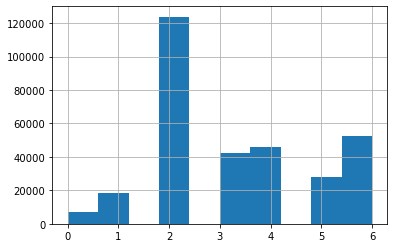

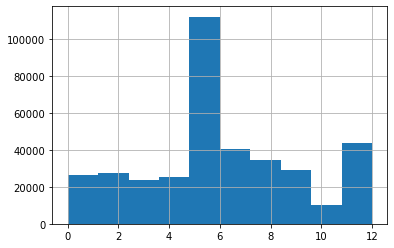

In [24]:
# Plot histograms of labels for both seasons
labeledData_R['Label'].hist()
plt.show()
labeledData_K['Label'].hist()
plt.show()

CV F1 score for K-Means clusters is 0.9540738850765157


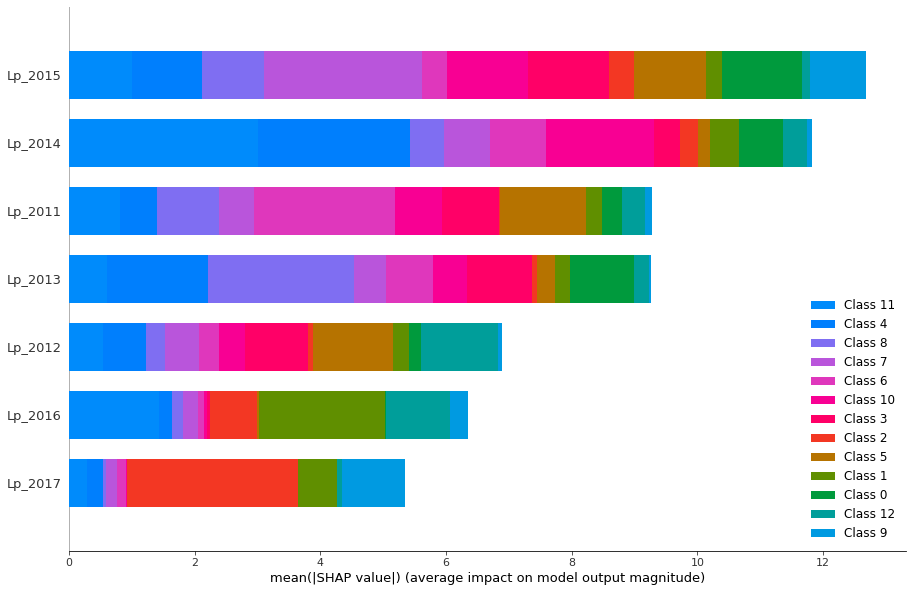

In [10]:
# ASSESS FEATURES IMPORTANCES 
# WITH A CLASSIFIER TRAINED WITH OUR CLUSTERS

# Setting the objects to category 
lgbm_data = data_R_db.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

# KMeans clusters
clf_km = LGBMClassifier(colsample_bytree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmeans_labels_R, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}') #tells how much clusters are significants

# Fit the model
clf_km.fit(lgbm_data, kmeans_labels_R)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

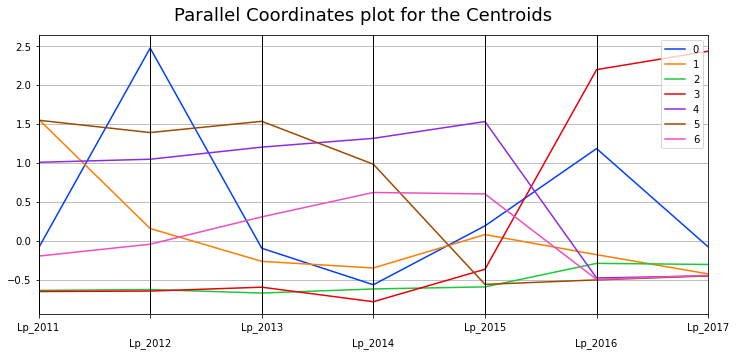

In [26]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans_R.cluster_centers_, columns=data_R_db.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 7)

RABI


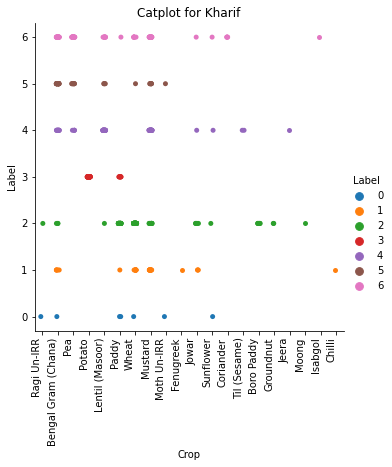

KHARIF


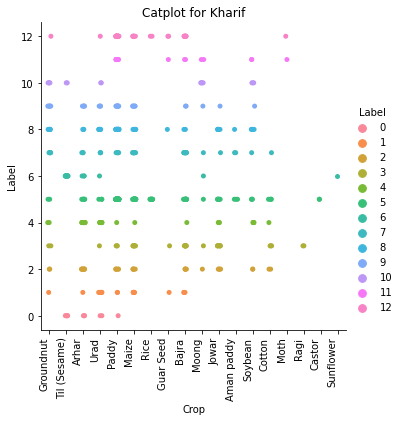

In [27]:
print("RABI")
labeledData_R.columns
sns.catplot(x='Crop', y='Label', hue='Label', data=labeledData_R.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()

print("KHARIF")
labeledData_K.columns
sns.catplot(x='Crop', y='Label', hue='Label', data=labeledData_K.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()

#### 2 ways of projecting data in a 2D space

##### PCA

In [28]:
print("pca for Rabi")
pca_R = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_R_db.sample(frac=1, random_state=0)[:10000])
pca_data_R=pca_R.row_coordinates(data_R_db)

print("pca for Kharif")
pca_K = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_K_db.sample(frac=1, random_state=0)[:10000])
pca_data_K=pca_K.row_coordinates(data_K_db)

pca for Rabi
pca for Kharif


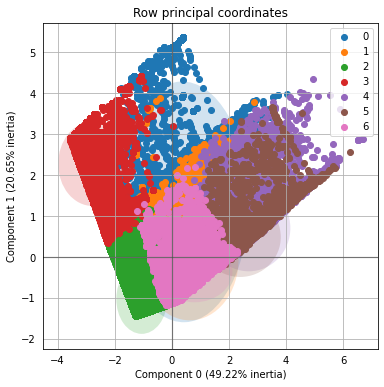

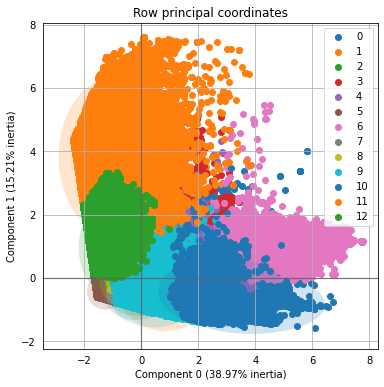

In [29]:
ax_R = pca_R.plot_row_coordinates(data_R_db, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_R, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

ax_K = pca_K.plot_row_coordinates(data_K_db, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_K, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

##### TSNE

In [30]:
from sklearn.manifold import TSNE
import plotly.express as px

# Use a sub-sample for computational time purpose
nb_samples = 1000

data_test = data_R_db.copy()
labels = np.array(labels_R)
data_test['Label'] = labels
data_test = data_test.sample(frac=1, random_state=0)[:nb_samples]
data_test

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Label
key,,,,,,,,
karnataka_mysore_piriyapatna_bettadapura_bettada thunga,-0.744326,0.922374,0.659009,-0.997198,-0.322250,0.459526,-0.451395,0
uttar pradesh_azamgarh_nizamabad_tahbarpur_lakhanpur,0.021523,-0.712410,0.828173,-0.690711,0.869006,-0.549593,-0.451395,6
uttar pradesh_sonbhadra_robertsganj_robertsganj_aamdeeh,1.085343,1.789983,0.900041,0.422025,0.442881,-0.549593,-0.451395,5
uttar pradesh_budaun_bilsi_islamnagar_gadhikhanpur,-0.744326,-0.712410,-0.405015,-0.997198,-0.759418,2.349214,2.638710,3
rajasthan_pratapgarh_pratapgarh___,0.029943,-0.611052,0.189543,-0.997198,0.454520,-0.444772,-0.451395,2
...,...,...,...,...,...,...,...,...
uttar pradesh_bareilly_bahedi_bahedi_sikari,-0.351923,-0.712410,-0.786921,0.684647,1.087546,-0.549593,-0.451395,6
west bengal_bardhaman_ausgram-i__gushkara municipality,-0.273268,-0.712410,-0.786921,-0.971377,-0.759418,0.289453,0.098242,2
uttar pradesh_rampur_milak_milak_duganpur,-0.744326,-0.712410,-0.786921,-0.997198,2.025314,2.225915,2.486637,3


In [31]:
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(data_test.drop(columns=["Label"]))
fig = px.scatter(
    projections, x=0, y=1,
    color=data_test.Label.astype(str), labels={'color': 'Label'}
)
fig.show()

In [32]:
tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(data_test.drop(columns=["Label"]))
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=data_test.Label.astype(str), labels={'color': 'Label'}
)
fig.update_traces(marker_size=8)
fig.show()

# K-Prototypes avec contraintes


In [5]:
# Format datasets for k-prototype
def find_state(key) : 
    return key.split('_')[0]

collumns_db= [f'Lp_{i}' for i in range(2011,2018)] 
collumns = collumns_db + ['Crop']

Rabi = regroup_crop(data_R)
Rabi = Rabi[collumns]
Rabi = Rabi.reset_index()
Rabi['State']=(Rabi.reset_index())['key'].map(find_state)
Rabi= Rabi.set_index('key')
Rabi = add_climate_clusters(Rabi, rabi = True, lower=True)
Rabi = add_crop_categories(Rabi, rabi = True).drop(columns=['Crop', 'State'])

Kharif = regroup_crop(data_K)
Kharif = Kharif[collumns]
Kharif = Kharif.reset_index()
Kharif['State']=(Kharif.reset_index())['key'].map(find_state)
Kharif= Kharif.set_index('key')
Kharif = add_climate_clusters(Kharif, rabi = False, lower=True)
Kharif = add_crop_categories(Kharif, rabi = False).drop(columns=['Crop', 'State'])
Kharif.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,climate_clusters,crop_categories
key,,,,,,,,,
andhra pradesh_anantapur_agali__agali,3.202628,3.097340,2.966815,1.416728,2.163674,3.228176,-0.386329,2,Legumineuses
andhra pradesh_anantapur_agali__akkagaladevarahalli,3.195926,3.089027,3.053232,1.900648,1.955517,3.220697,-0.386329,2,Legumineuses
andhra pradesh_anantapur_agali__hulikeradevarahalli,3.202628,3.097340,2.989434,1.416728,2.163674,3.228176,-0.386329,2,Legumineuses
andhra pradesh_anantapur_agali__inagalore,3.195926,3.089027,3.022794,1.900648,1.955517,3.220697,-0.386329,2,Legumineuses
andhra pradesh_anantapur_agali__kodihalli,3.202628,3.097340,2.966815,1.416728,2.163674,3.228176,-0.386329,2,Legumineuses


In [6]:
def cat_diss_pen(pen) :
    '''Create our own categorical dissimilarity function with a custom penalization (2d-array)'''
    def categorical_dissimilarity(a, b, **_):
        '''Dissimilarity function with penalization'''
        return (a[:,0] != b[0])*pen[0] + (a[:,1] != b[1])*pen[1]
    return categorical_dissimilarity

db_index= 1.813835642754744


,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,climate_clusters,crop_categories,cluster
0,-0.6631795798129266,-0.6295538748054805,-0.6569266258185746,-0.4325138044693752,-0.4986939879353479,-0.3787344579143125,-0.3753031800497285,3,Cereales,0
1,1.4380969063413604,1.2649370774272883,1.1445382536285869,1.0504664353023963,1.4727192265975164,-0.38844456780505654,-0.4513949475366867,3,Herbace,1
2,0.7728544103982915,0.06133848732029791,-0.13032993674520915,0.29123103122203226,-0.06175841466495524,-0.39594947256397295,-0.4342831896629592,3,Herbace,2
3,-0.6011546605021366,3.5797285564229093,-0.07586732233498926,-0.8098499017639029,0.06748790065530341,2.2011453567181745,1.2209577049298868,0,Riz,3
4,-0.029630024931385338,0.11397936107979628,0.8304142216548506,0.8612626128375793,0.9309168740592065,-0.5275681911453068,-0.4506029341371752,3,Legumineuses,4
5,-0.6630280318509534,-0.6752803315121465,-0.5775162757533087,-0.8740875588409703,-0.3243549510832459,2.2120298161965706,2.5186594359084773,3,Legumes ou fleurs,5
6,1.3024875035309522,1.313040438636275,1.5384122575532422,0.8527242922409767,-0.7002034866130729,-0.498050682661433,-0.45139494753668685,1,Legumineuses,6
7,-0.6105233858944105,-0.6268041135066659,-0.73653163217568,-0.8933246965643449,-0.5568682656840617,-0.41843964652631377,-0.20736567898373398,1,Riz,7
8,-0.3989837655791468,-0.34970919965061326,-0.6743912803317579,-0.924596938166713,-0.3121856173287974,1.229699996818486,0.05424751722260057,0,Riz,8


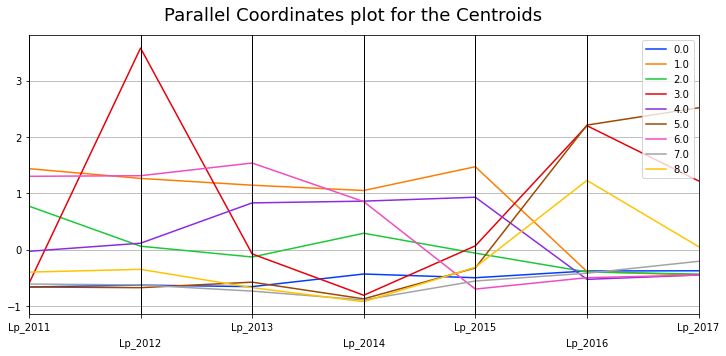

In [13]:
# SELECT SEASON 
season_str = 'Rabi'

if season_str == 'Rabi':
    Season = Rabi
else :
    Season = Kharif

# SELECT THE NUMBER OF CLUSTERS
nb_clusters= 9

# '7' = 'climate_clusters' and '8' = 'crop_categories'
categorical_columns = [7,8]
#Intensity of penalisation
pen = 2.9*np.array([0.9,1.3]) 
#the fisrt value of pen penalize the category 'climate_clusters' 
# and the second value 'crop_categories"

# COMPUTE CLUSTERING ON A SUB-SAMPLE (for computational time purpose)
nb_samples=1000
Season_test=Season.sample(frac=1, random_state=0)[:nb_samples]
categorical_dissimilarity = cat_diss_pen(pen)
kproto = KPrototypes(n_clusters= nb_clusters, init='Cao', n_jobs = 2, 
                     cat_dissim=categorical_dissimilarity) #gamma= 1, 
labels= kproto.fit_predict(Season_test, categorical=categorical_columns)

# CONCATENATE DATA WITH PREDICTIONS
labeledData= Season_test.copy(deep=True)
labeledData['Label'] = np.array(labels).astype(int)

# DAVIES-BOULDIN INDEX FOR THE PRED
db_index = davies_bouldin_score(Season_test[collumns_db], labels)
print('db_index=', db_index)

# VISUALIZATION OF THE CENTROIDS
centroids = pd.DataFrame(kproto.cluster_centroids_, columns=Season_test.columns)
centroids['cluster'] = centroids.index.astype(int)
centr_displ = centroids.drop(columns=['climate_clusters','crop_categories']).astype(float)
display_parallel_coordinates_centroids(centr_displ, nb_clusters)
centroids

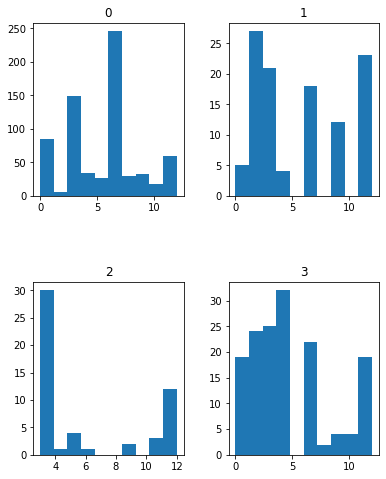

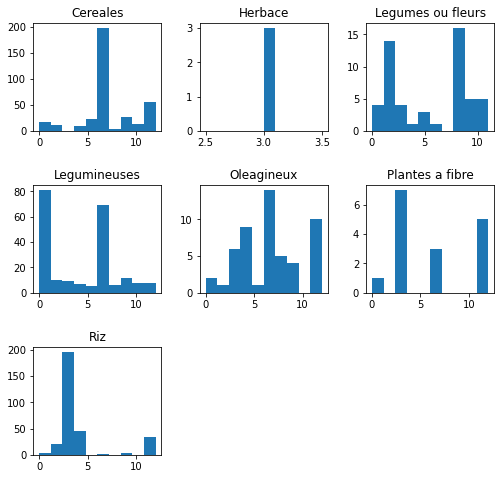

In [82]:
# PLOT HISTOGRAMS OF LABELS FOR EACH CATEGORY 
labeledData['Label'].hist(by=labeledData['climate_clusters'], figsize = (6,8), xrot = 0)
plt.show()

labeledData['Label'].hist(by=labeledData['crop_categories'], figsize = (8,8), xrot = 0)
plt.show()

<Figure size 5040x5040 with 0 Axes>

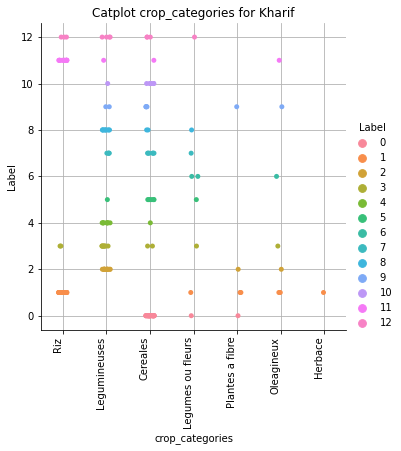

<Figure size 5040x5040 with 0 Axes>

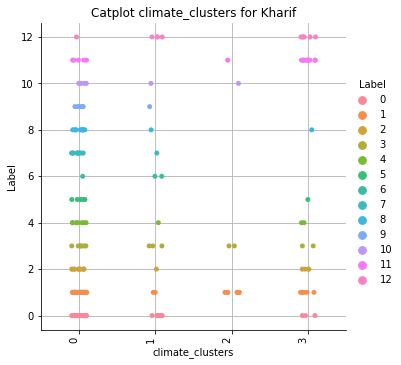

In [73]:
# PLOT THE CATPLOTS FOR EACH CATEGORY
for cat in ['crop_categories','climate_clusters'] :
    plt.figure(figsize=(70,70)) 
    sns.catplot(x=cat, y='Label', hue='Label', data=labeledData.sample(frac=1, random_state=0)[:200]) #sample is use to shuffle the rows of the dataset
    plt.xticks(rotation=90, ha='right')
    plt.title(f'Catplot {cat} for {season_str}')
    plt.grid()
    plt.show()

CV F1 score for K-Means clusters is 0.9384667825305065


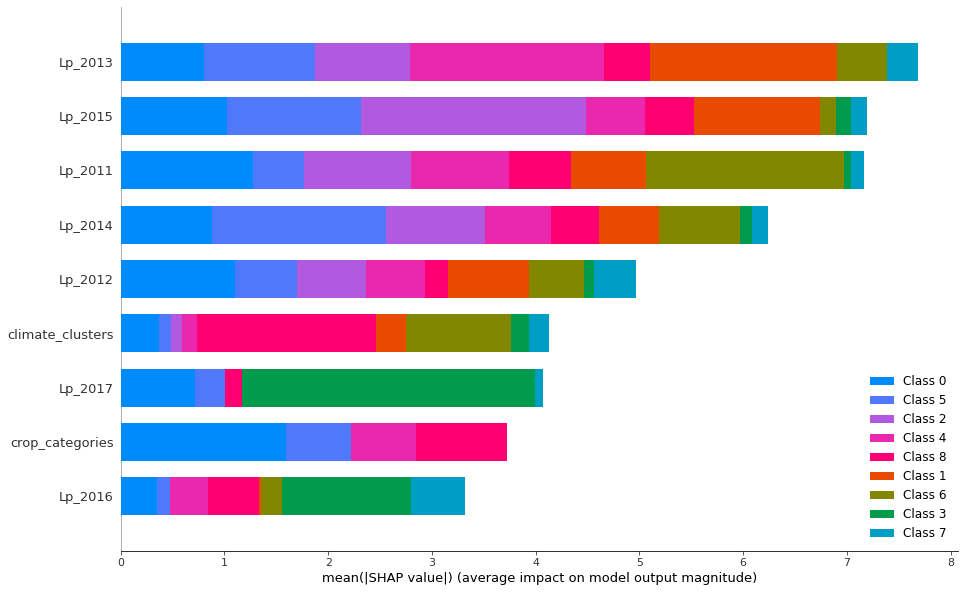

In [101]:
# ASSESS FEATURES IMPORTANCES 
# WITH A CLASSIFIER TRAINED WITH OUR CLUSTERS

# Setting the objects to category 
lgbm_data = Season_test.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

# KMeans clusters classification
clf_km = LGBMClassifier(colsample_bytree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}') #tells how much clusters are significants

# Fit the model
clf_km.fit(lgbm_data, labels)

# SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

## Finetunning

In [56]:
def compute_clusters(Season_df, nb_clusters=7, pen =[1,1], nb_samples=200, all_data=False):
    '''Compute the clusters with K-prototypes, save the db_index, labels, and the centroids of the clusters'''
    if all_data == True :
        Season_test = Season_df
    else :
        Season_test=Season_df.sample(frac=1, random_state=0)[:nb_samples]
    
    #'7' -> 'climate_clusters' and '8' -> 'crop_categories'
    categorical_columns = [7,8]
    categorical_dissimilarity = cat_diss_pen(pen)
    kproto = KPrototypes(n_clusters= nb_clusters, init='Cao', n_jobs = 2, 
                        cat_dissim=categorical_dissimilarity) #gamma= 1, 
    labels= kproto.fit_predict(Season_test, categorical=categorical_columns)

    db_index = davies_bouldin_score(Season_test[collumns_db], labels)

    centroids = pd.DataFrame(kproto.cluster_centroids_, columns=Season_test.columns)
    centroids['cluster'] = centroids.index

    return db_index, labels, centroids

def plot_db(pen =[1,1], nb_samples=200,all_data=False):
    '''Plot db curve in order the find the optimal k'''
    for name,season_df in zip(['Rabi', 'Kharif'],[Rabi, Kharif]):
        DB=[]
        for i in trange(2,15):
            db,_,__ = compute_clusters(season_df, nb_clusters=i,pen =pen, nb_samples=nb_samples,all_data=False)
            DB.append(db)
        plt.plot(np.arange(2,15),DB)
        plt.title(f'Db in function of k for {name}')
        plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

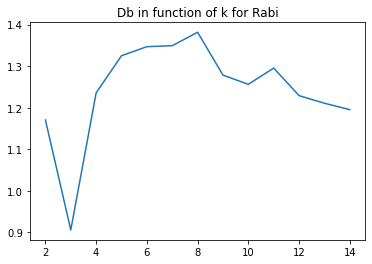

  0%|          | 0/13 [00:00<?, ?it/s]

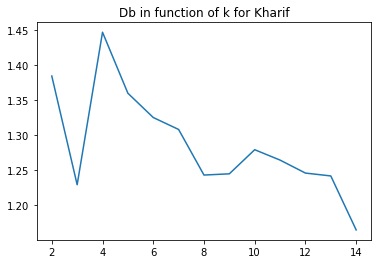

In [28]:
plot_db(nb_samples=400, pen=[0,0])

  0%|          | 0/13 [00:00<?, ?it/s]

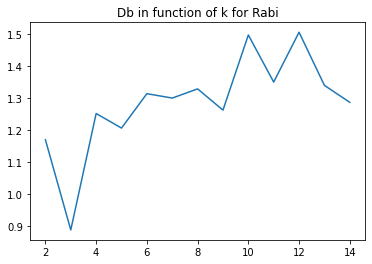

  0%|          | 0/13 [00:00<?, ?it/s]

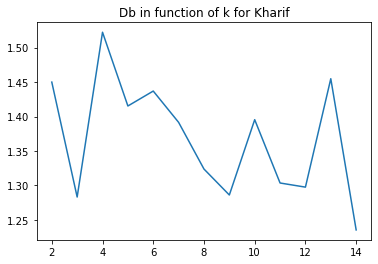

In [67]:
plot_db(nb_samples=2000)

# Final Clusters

In [3]:
print("Rabi")
pred_R=pd.read_csv('predictions/free/kproto_labels_Rabi_pres_k8.csv').set_index('key')
labels_R= np.array(pred_R)
db_index_R = davies_bouldin_score(data_R_db, labels_R)
print("db_index_R=", db_index_R)
plot_on_map(labels_R,pathData_R,'District')

print("Kharif")
pred_K=pd.read_csv('predictions/free/kproto_labels_Kharif_pres_k6.csv').set_index('key')
labels_K= np.array(pred_K)
db_index_K = davies_bouldin_score(data_K_db, labels_K)
print("db_index_K=", db_index_K)
plot_on_map(labels_K,pathData_K,'District')

Rabi


FileNotFoundError: [Errno 2] No such file or directory: 'predictions/free/kproto_labels_Rabi_pres_k8.csv'